# Utility measures for synthetic data before and after the anonymization algorithm is applied.

In [1]:
import pandas as pd
import numpy as np
import itertools

from pointpats import PointPattern
from pointpats.distance_statistics import L

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

from pyproj import Proj
from geopy.geocoders import Nominatim

C:\Users\camer\anaconda3\lib\site-packages\libpysal\weights\util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


In [2]:
train_data = pd.read_csv("Data/train_dataset.csv")

In [3]:
holdout_data = [pd.read_csv("Data/holdout_" + str(i) + ".csv") for i in range(20)]

In [4]:
# sXs_mnl_ks = [pd.read_csv("Data/synthetic_datasets/logistic_logistic_ks_" + str(i) + ".csv") for i in range(20)]
sXs_mnl_pmse = [pd.read_csv("Data/synthetic_datasets/logistic_logistic_pmse_" + str(i) + ".csv") for i in range(20)]
sXs_mnl_inf_pmse = [pd.read_csv("Data/synthetic_datasets/logistic_logistic_inf_pmse_" + str(i) + ".csv") for i in range(20)]

In [5]:
# sXs_cart_ks = [pd.read_csv("Data/synthetic_datasets/cart_logistic_ks_" + str(i) + ".csv") for i in range(20)]
# sXs_cart_pmse = [pd.read_csv("Data/synthetic_datasets/cart_logistic_pmse_" + str(i) + ".csv") for i in range(20)]

# sXs_cart_mb_ks = [pd.read_csv("Data/synthetic_datasets/cart_mb_logistic_ks_" + str(i) + ".csv") for i in range(20)]
sXs_cart_mb_pmse = [pd.read_csv("Data/synthetic_datasets/cart_mb_logistic_pmse_" + str(i) + ".csv") for i in range(20)]
sXs_cart_mb_inf_pmse = [pd.read_csv("Data/synthetic_datasets/cart_mb_inf_logistic_pmse_" + str(i) + ".csv") for i in range(20)]

In [6]:
sXs_mostly = [pd.read_csv("Data/synthetic_datasets/mostly_" + str(i) + ".csv") for i in range(20)]

***

## Utility Measure 1 - pMSE Ratios

In [7]:
# def cart_pmse_ratio(original_data, synthetic_data_sets):
    
#     null_pmse_list = []
    
#     inds = np.arange(len(synthetic_data_sets))
    
#     combo_list = list(itertools.combinations(inds, 2))
    
#     for combo in combo_list:
    
#         s1 = synthetic_data_sets[combo[0]]
#         s2 = synthetic_data_sets[combo[1]]
    
#         N_orig = s1.shape[0]
#         N_synth = s2.shape[0]
    
#         c = N_synth/(N_synth+N_orig)
    
#         full_X = pd.concat([s1, s2], axis=0).reset_index(drop=True)
    
#         full_X = preprocessing.StandardScaler().fit_transform(full_X)

#         y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
#         cart = DecisionTreeClassifier(min_samples_split=20,
#                                       min_samples_leaf=int(np.round(20/3)),
#                                       ccp_alpha=0.0001,
#                                       max_depth=30)
    
#         cart.fit(X=full_X, y=y)
    
#         probs = cart.predict_proba(full_X)
    
#         pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
        
#         null_pmse_list.append(pMSE)
    
#     pmse_list = []
    
#     for s in synthetic_data_sets:
    
#         N_orig = original_data.shape[0]
#         N_synth = s.shape[0]
    
#         c = N_synth/(N_synth+N_orig)
    
#         full_X = pd.concat([original_data, s], axis=0).reset_index(drop=True)
    
#         full_X = preprocessing.StandardScaler().fit_transform(full_X)

#         y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
#         cart = DecisionTreeClassifier(min_samples_split=20,
#                                       min_samples_leaf=int(np.round(20/3)),
#                                       ccp_alpha=0.0001,
#                                       max_depth=30)
    
#         cart.fit(X=full_X, y=y)
    
#         probs = cart.predict_proba(full_X)
    
#         pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
        
#         pmse_list.append(pMSE)
        
#     return np.array(pmse_list)/np.mean(null_pmse_list), null_pmse_list

In [8]:
def pmse_ratio(original_data, synthetic_data):
    
    N_synth = synthetic_data.shape[0]
    N_orig = original_data.shape[0]
    
    # combine original and synthetic datasets
    full_X = pd.concat([original_data, synthetic_data], axis=0).reset_index(drop=True)
    
#     full_X["age"] = full_X["age"].astype('category')
    
#     age_dummies = pd.get_dummies(full_X['age'], drop_first=True)
    
#     age_dummies.columns = [str(x) for x in age_dummies.columns]
    
#     full_X = full_X.drop("age", axis=1)
    
#     full_X = pd.concat([full_X, age_dummies], axis=1)
    
    # generate interactions and powers of variables
    poly = PolynomialFeatures(3, interaction_only=False, include_bias=False)
    
    full_X = poly.fit_transform(full_X)
    
#     full_X = full_X[:,:-36]

    # scale the combined dataset
    full_X = preprocessing.StandardScaler().fit_transform(full_X)
    
    c = N_synth/(N_synth+N_orig)

    y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
    pMSE_model = LogisticRegression(penalty=None, max_iter=1000).fit(full_X, y)
    
    probs = pMSE_model.predict_proba(full_X)
    
    pMSE = 1/(N_synth+N_orig) * np.sum((probs[:,1] - c)**2)
    
    e_pMSE = 2*(full_X.shape[1])*(1-c)**2 * c/(N_synth+N_orig)
        
    return pMSE/e_pMSE

In [9]:
np.mean([pmse_ratio(train_data, x) for x in holdout_data])

C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.9353534575308771

In [10]:
# ratios_mnl_ks = [pmse_ratio(train_data, Y) for Y in sXs_mnl_ks]
ratios_mnl_pmse = [pmse_ratio(train_data, Y) for Y in sXs_mnl_pmse]
ratios_mnl_inf_pmse = [pmse_ratio(train_data, Y) for Y in sXs_mnl_inf_pmse]
# ratios, null_ratios = cart_pmse_ratio(train_data, sXs_mnl)
# print(np.mean(ratios_mnl_ks))
print(np.mean(ratios_mnl_pmse))
print(np.mean(ratios_mnl_inf_pmse))

C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.9904468212700696
2.6507741305236223


In [11]:
# ratios_cart_ks = [pmse_ratio(train_data, Y) for Y in sXs_cart_ks]
# ratios_cart_pmse = [pmse_ratio(train_data, Y) for Y in sXs_cart_pmse]

# ratios_cart_mb_ks = [pmse_ratio(train_data, Y) for Y in sXs_cart_mb_ks]
ratios_cart_mb_pmse = [pmse_ratio(train_data, Y) for Y in sXs_cart_mb_pmse]
ratios_cart_mb_inf_pmse = [pmse_ratio(train_data, Y) for Y in sXs_cart_mb_inf_pmse]
# ratios, null_ratios = cart_pmse_ratio(train_data, sXs_mnl)
# print(np.mean(ratios_cart_ks))
# print(np.mean(ratios_cart_pmse))

# print(np.mean(ratios_cart_mb_ks))
print(np.mean(ratios_cart_mb_pmse))
print(np.mean(ratios_cart_mb_inf_pmse))

C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

0.9501986077097611
2.5042834438993


In [12]:
ratios_mostly = [pmse_ratio(train_data, Y) for Y in sXs_mostly]
# mostly_ratios, null_mostly_ratios = cart_pmse_ratio(train_data, sXs_mostly)
np.mean(ratios_mostly)

C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\camer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

1.250419916712535

***

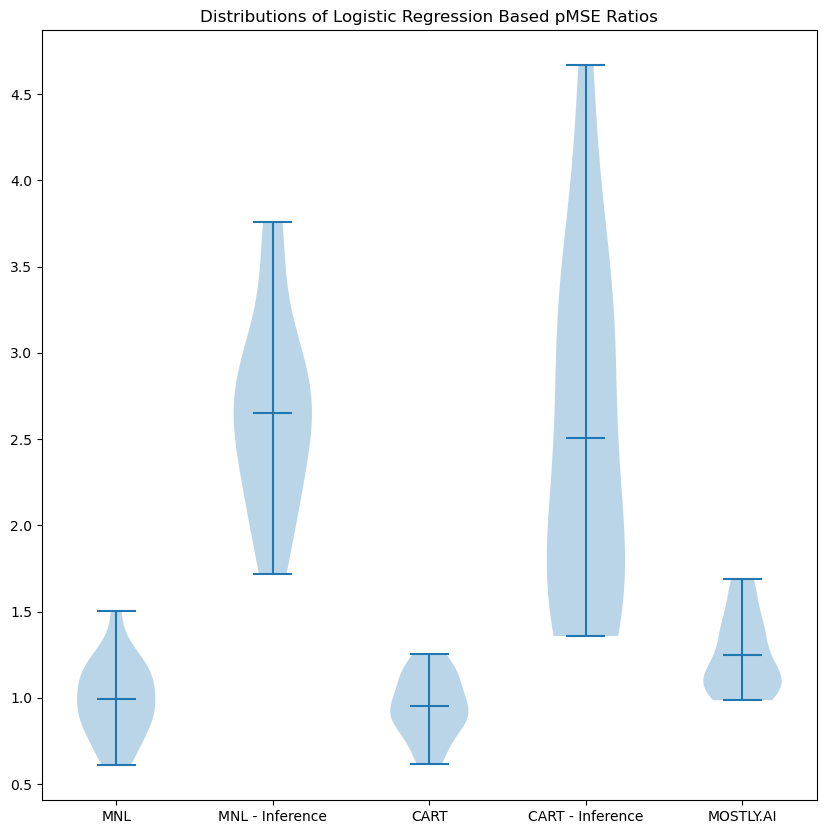

In [13]:
# Combine data
plot_data = list([ratios_mnl_pmse, ratios_mnl_inf_pmse, ratios_cart_mb_pmse, ratios_cart_mb_inf_pmse, ratios_mostly])

fig, ax = plt.subplots(figsize=(10,10))

xticklabels = ["MNL", "MNL - Inference", "CART", "CART - Inference", "MOSTLY.AI"]
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(xticklabels)

ax.violinplot(plot_data, showmeans=True)

plt.title("Distributions of Logistic Regression Based pMSE Ratios")

plt.show()

***

## Utility Measure 2 - K and L Functions

Calculate L function for original and synthetic datasets and plot.

In [14]:
# L function value for original data
l_orig = L(PointPattern(train_data.loc[:,['latitude', 'longitude']])).l

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [15]:
# L function values for synthetic data
# l_mnl_inf = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_mnl_inf]
l_mnl_inf_pmse = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_mnl_inf_pmse]
l_mnl_pmse = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_mnl_pmse]

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based 

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based 

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [16]:
# L function values for anonymized synthetic data
# l_cart_ks = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_cart_ks]
# l_cart_pmse = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_cart_pmse]

# L function values for anonymized synthetic data
# l_cart_mb_ks = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_cart_mb_ks]
l_cart_mb_inf_pmse = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_cart_mb_inf_pmse]
l_cart_mb_pmse = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_cart_mb_pmse]

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based 

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based 

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [17]:
# L function values for MOSTLY.AI synthetic data
l_mostly = [L(PointPattern(Y.loc[:,['latitude', 'longitude']])).l for Y in sXs_mostly]

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based 

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [18]:
# pos_sXs_mnl_ks = [Y.loc[Y.state==1.0,:] for Y in sXs_mnl_ks]
pos_sXs_mnl_inf_pmse = [Y.loc[Y.state==1.0,:] for Y in sXs_mnl_inf_pmse]
pos_sXs_mnl_pmse = [Y.loc[Y.state==1.0,:] for Y in sXs_mnl_pmse]

In [19]:
# pos_sXs_cart_ks = [Y.loc[Y.state==1.0,:] for Y in sXs_cart_ks]
# pos_sXs_cart_pmse = [Y.loc[Y.state==1.0,:] for Y in sXs_cart_pmse]

# pos_sXs_cart_mb_ks = [Y.loc[Y.state==1.0,:] for Y in sXs_cart_mb_ks]
pos_sXs_cart_mb_inf_pmse = [Y.loc[Y.state==1.0,:] for Y in sXs_cart_mb_inf_pmse]
pos_sXs_cart_mb_pmse = [Y.loc[Y.state==1.0,:] for Y in sXs_cart_mb_pmse]

In [20]:
pos_sXs_mostly = [Y.loc[Y.state==1.0,:] for Y in sXs_mostly]

In [21]:
pos_l_orig = L(PointPattern(train_data.loc[train_data.state==1.0,["latitude", "longitude"]])).l

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [22]:
# pos_l_mnl_ks = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_mnl_ks]
pos_l_mnl_inf_pmse = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_mnl_inf_pmse]
pos_l_mnl_pmse = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_mnl_pmse]

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based 

In [23]:
# pos_l_cart_ks = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_cart_ks]
# pos_l_cart_pmse = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_cart_pmse]

# pos_l_cart_mb_ks = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_cart_mb_ks]
pos_l_cart_mb_inf_pmse = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_cart_mb_inf_pmse]
pos_l_cart_mb_pmse = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_cart_mb_pmse]

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based 

In [24]:
pos_l_mostly = [L(PointPattern(Y.loc[:,["latitude", "longitude"]])).l for Y in pos_sXs_mostly]

C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
C:\Users\camer\anaconda3\lib\site-packages\libpysal\cg\shapes.py:1492: FutureWarning: Objects based 

In [25]:
def L_plot(ax1, line_orig, line_synthetic, plot_title):
    
    # x values to plot
    x = np.arange(0, 1.2, 0.1)
    
    # average L function for synthetic data
    synthetic_mean = np.mean(line_synthetic, axis=0)

    # calculate 95% empirical confidence interval for L function value for synthetic data
    qs = np.quantile(line_synthetic, (0.025, 0.975), axis=0)
    
    ax1.plot(x, line_orig, label = 'Original')
    ax1.plot(x, synthetic_mean, label = 'Avg Synthetic')
    ax1.fill_between(x, qs[0,:], qs[1,:], alpha = 0.3)
    ax1.legend(loc = 'upper right')
    ax1.set_title(plot_title)
    ax1.set_xlabel('h')
    ax1.set_ylabel('L(h)')
    ax1.set_ylim(0.00, 1.10)

L functions for all locations.

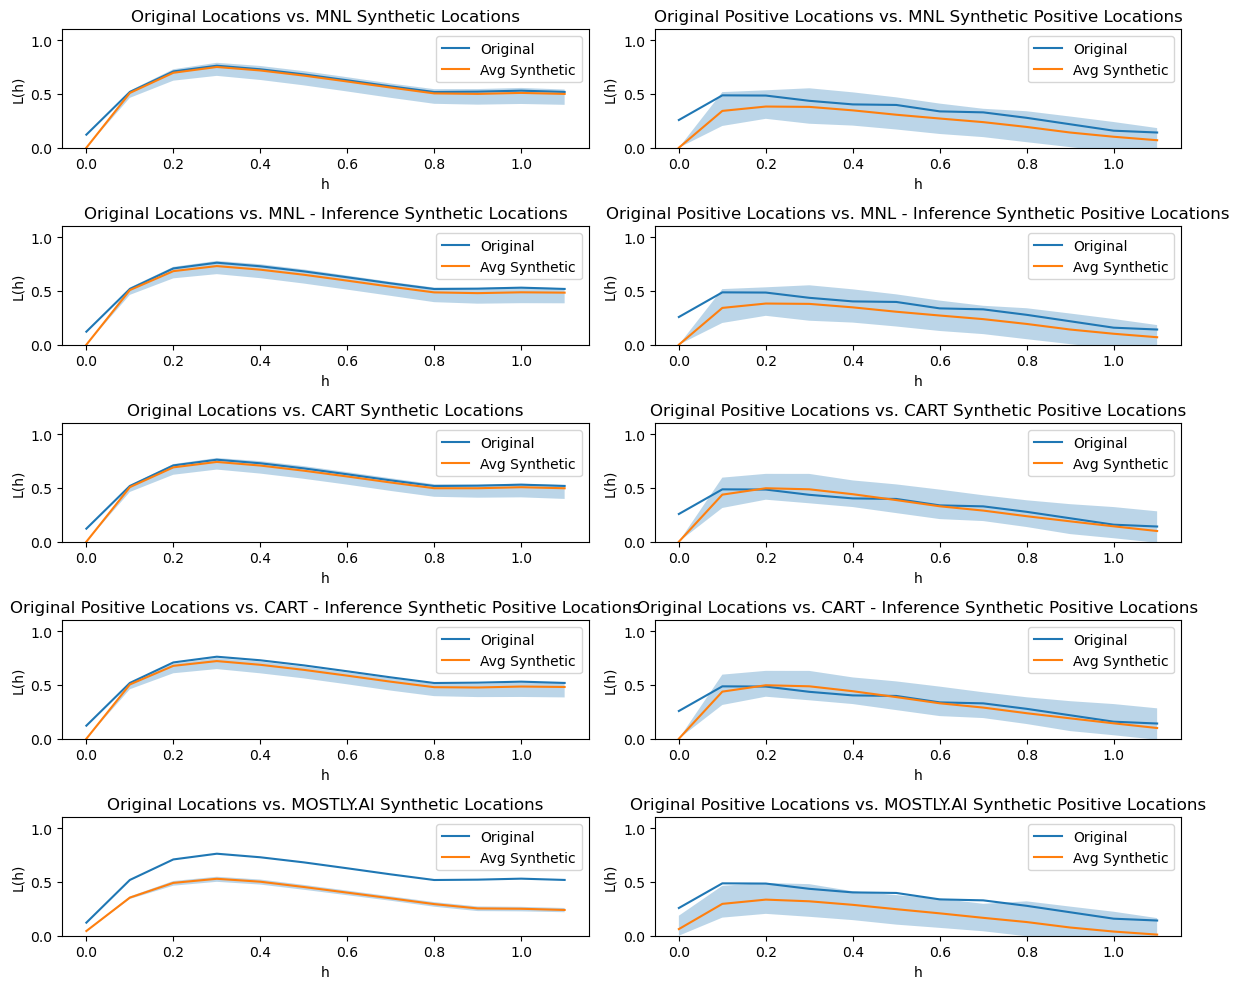

In [39]:
fig, ax = plt.subplots(5, 2, figsize=(12,10))

# L_plot(ax[0,0], l_orig, l_mnl_ks, "Original Locations vs. MNL KS Synthetic Locations")
L_plot(ax[0,0], l_orig, l_mnl_pmse, "Original Locations vs. MNL Synthetic Locations")
L_plot(ax[0,1], pos_l_orig, pos_l_mnl_pmse, "Original Positive Locations vs. MNL Synthetic Positive Locations")

L_plot(ax[1,0], l_orig, l_mnl_inf_pmse, "Original Locations vs. MNL - Inference Synthetic Locations")
L_plot(ax[1,1], pos_l_orig, pos_l_mnl_inf_pmse, "Original Positive Locations vs. MNL - Inference Synthetic Positive Locations")

L_plot(ax[2,0], l_orig, l_cart_mb_pmse, "Original Locations vs. CART Synthetic Locations")
L_plot(ax[2,1], pos_l_orig, pos_l_cart_mb_pmse, "Original Positive Locations vs. CART Synthetic Positive Locations")

L_plot(ax[3,0], l_orig, l_cart_mb_inf_pmse, "Original Positive Locations vs. CART - Inference Synthetic Positive Locations")
L_plot(ax[3,1], pos_l_orig, pos_l_cart_mb_inf_pmse, "Original Locations vs. CART - Inference Synthetic Positive Locations")

L_plot(ax[4,0], l_orig, l_mostly, "Original Locations vs. MOSTLY.AI Synthetic Locations")
L_plot(ax[4,1], pos_l_orig, pos_l_mostly, "Original Positive Locations vs. MOSTLY.AI Synthetic Positive Locations")

plt.tight_layout()

# Utility Measure 3: Visual Comparison of Locations

Visual comparison of location distributions.

In [51]:
def scatter_plot(ax1, location_data, plot_title, xlab, ylab):
    
    ax1.scatter(location_data.longitude, location_data.latitude)
    
    ax1.set_title(plot_title)
    ax1.set_xlabel(xlab)
    ax1.set_ylabel(ylab)
    ax1.set_ylim(-3, 2)
    ax1.set_xlim(-2, 2.5)

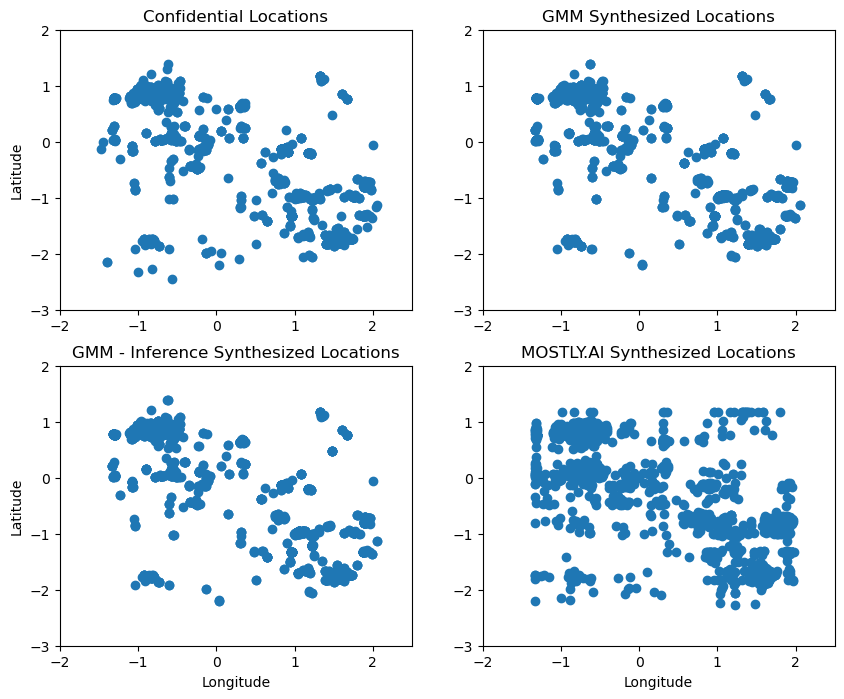

In [53]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))
scatter_plot(ax[0,0], train_data, "Confidential Locations", "", "Latitude")
scatter_plot(ax[0,1], sXs_mnl_pmse[0], "GMM Synthesized Locations", "", "")
scatter_plot(ax[1,0], sXs_mnl_inf_pmse[0], "GMM - Inference Synthesized Locations", "Longitude", "Latitude")
scatter_plot(ax[1,1], sXs_mostly[0], "MOSTLY.AI Synthesized Locations", "Longitude", "")

***

Look at plots of the points with positive mark values.

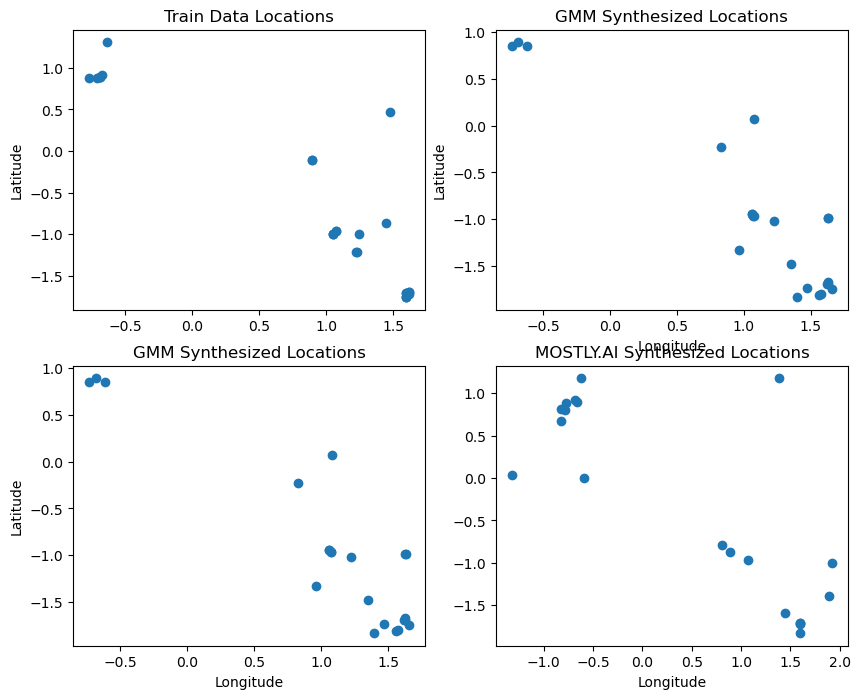

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))
scatter_plot(ax[0,0], train_data.loc[train_data.state==1.0,:], "Train Data Locations", "", "Latitude")
scatter_plot(ax[0,1], sXs_mnl_pmse[0].loc[sXs_mnl_pmse[0].state==1.0,:], "GMM Synthesized Locations", "Longitude", "Latitude")
scatter_plot(ax[1,0], sXs_mnl_inf_pmse[0].loc[sXs_mnl_inf_pmse[0].state==1.0,:], "GMM Synthesized Locations", "Longitude", "Latitude")
scatter_plot(ax[1,1], sXs_mostly[0].loc[sXs_mostly[0].state==1.0,:], "MOSTLY.AI Synthesized Locations", "Longitude", "")

***

Analysis specific utility.

Use logistic regression to predict COVID-19 death based on latitude and longitude, age, and sex.

Compute the model for the original data.

In [54]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant

In [165]:
def logit_param_getter(model_data):
    predictors = model_data.loc[:, ["latitude", "longitude", "sex", "age"]]
    predictors = add_constant(predictors)
    state_logit = Logit(endog=model_data.loc[:, 'state'], exog=predictors)
    logit_results = state_logit.fit()
    l_params = logit_results.params
    l_se = np.sqrt(np.diag(logit_results.cov_params()))
    return {"params": l_params, "l_se": l_se}

In [166]:
def logit_ci_getter(model_data):
    predictors = model_data.loc[:, ["latitude", "longitude", "sex", "age"]]
    predictors = add_constant(predictors)
    state_logit = Logit(endog=model_data.loc[:, 'state'], exog=predictors)
    logit_results = state_logit.fit()
    return logit_results.conf_int().reset_index(drop=True)

In [167]:
def standardized_param_diff(orig_data, synth_data):
    orig_params = logit_param_getter(orig_data)
    synth_params = logit_param_getter(synth_data)
    stan_params = [np.abs(j - synth_params['params'][i]) / orig_params['l_se'][i] for i,j in enumerate(orig_params['params'])]
    return pd.Series(stan_params)

In [168]:
synthetic_data_sets = [holdout_data, sXs_mnl_pmse, sXs_mnl_inf_pmse, sXs_cart_mb_pmse, sXs_cart_mb_inf_pmse, sXs_mostly]
median_stan_coefs = [np.median(pd.concat([standardized_param_diff(train_data, x) for x in Y], axis=1)) for Y in synthetic_data_sets]
std_stan_coefs = [np.std(pd.concat([standardized_param_diff(train_data, x) for x in Y], axis=1), ddof=1) for Y in synthetic_data_sets]

Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017381
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.022818
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.024918
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.020073
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.019085
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.028316
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.027717
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.021483
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.022761
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.028543
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.036965
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.032019
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.027606
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.015155
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.014113
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012017
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.014531
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.009142
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.013020
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017318
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.020526
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012974
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.008979
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012718
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.010007
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012238
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012922
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [169]:
median_stan_coefs

[1.321319981994244,
 0.7890566232500109,
 1.2116077340459204,
 1.2073038816128756,
 1.958321788894271,
 2.1347349090209375]

Calculate confidence interval overlap for a model applied to two data sets.

In [170]:
def interval_overlap(train_dataset, synth_dataset):
    train_ci = logit_ci_getter(train_dataset)
    synth_ci = logit_ci_getter(synth_dataset)
    
    IQ_list = []
    for i,row in train_ci.iterrows():
    
        us = synth_ci.iloc[int(i),1]
        ls = synth_ci.iloc[int(i),0]
        uo = row[1]
        lo = row[0]
    
        ui = np.min([uo, us])
    
        li = np.max([lo, ls])
    
        IQ_list.append( 0.5 * ( (ui - li)/(uo - lo) + (ui - li)/(us - ls) ) )
        
    return IQ_list

In [171]:
holdout_intervals = np.vstack([interval_overlap(train_data, x) for x in holdout_data])
mnl_pmse_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_mnl_pmse])
mnl_pmse_inf_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_mnl_inf_pmse])
# cart_ks_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_ks])
# cart_pmse_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_pmse])
# cart_ks_mb_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_mb_ks])
cart_pmse_mb_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_mb_pmse])
cart_pmse_mb_inf_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_cart_mb_inf_pmse])
mostly_intervals = np.vstack([interval_overlap(train_data, x) for x in sXs_mostly])

Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017381
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.022818
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.024918
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.020073
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.021938
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.019085
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.028316
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.027717
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.040575
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.025068
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.021861
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.028787
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017450
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.

In [174]:
np.median(holdout_intervals)

0.6329065033318173

In [175]:
np.median(mnl_pmse_intervals)

0.8127387786021227

In [176]:
np.median(mnl_pmse_inf_intervals)

0.7003984969425749

In [177]:
np.median(cart_pmse_mb_intervals)

0.6955657463755386

In [178]:
np.median(cart_pmse_mb_inf_intervals)

0.4544123579141903

In [179]:
np.median(mostly_intervals)

0.5419520181665455

In [180]:
def interval_overlap_plot(ax1, plotting_data, plot_title):
    
    xticklabels = ["Holdout", "MNL", "MNL - Inference", "CART", "CART - Inference", "MOSTLY.AI"]
    ax1.set_xticks([1, 2, 3, 4, 5, 6])
    ax1.set_xticklabels(xticklabels)
    
    ax1.violinplot(plotting_data, showmeans=True)
    ax1.set_title(plot_title)

    ax1.set_ylabel('Interval Overlap')
    ax1.set_ylim(-1.00, 1.00)

In [181]:
# Combine data
intercept_vals = list([holdout_intervals[:,0], mnl_pmse_intervals[:,0], mnl_pmse_inf_intervals[:,0], cart_pmse_mb_intervals[:,0], cart_pmse_mb_inf_intervals[:,0], mostly_intervals[:,0]])

latitude_vals = list([holdout_intervals[:,1], mnl_pmse_intervals[:,1], mnl_pmse_inf_intervals[:,1], cart_pmse_mb_intervals[:,1], cart_pmse_mb_inf_intervals[:,1], mostly_intervals[:,1]])

longitude_vals = list([holdout_intervals[:,2], mnl_pmse_intervals[:,2], mnl_pmse_inf_intervals[:,2], cart_pmse_mb_intervals[:,2], cart_pmse_mb_inf_intervals[:,2], mostly_intervals[:,2]])

sex_vals = list([holdout_intervals[:,3], mnl_pmse_intervals[:,3], mnl_pmse_inf_intervals[:,3], cart_pmse_mb_intervals[:,3], cart_pmse_mb_inf_intervals[:,3], mostly_intervals[:,3]])

age_vals = list([holdout_intervals[:,4], mnl_pmse_intervals[:,4], mnl_pmse_inf_intervals[:,4], cart_pmse_mb_intervals[:,4], cart_pmse_mb_inf_intervals[:,4], mostly_intervals[:,4]])

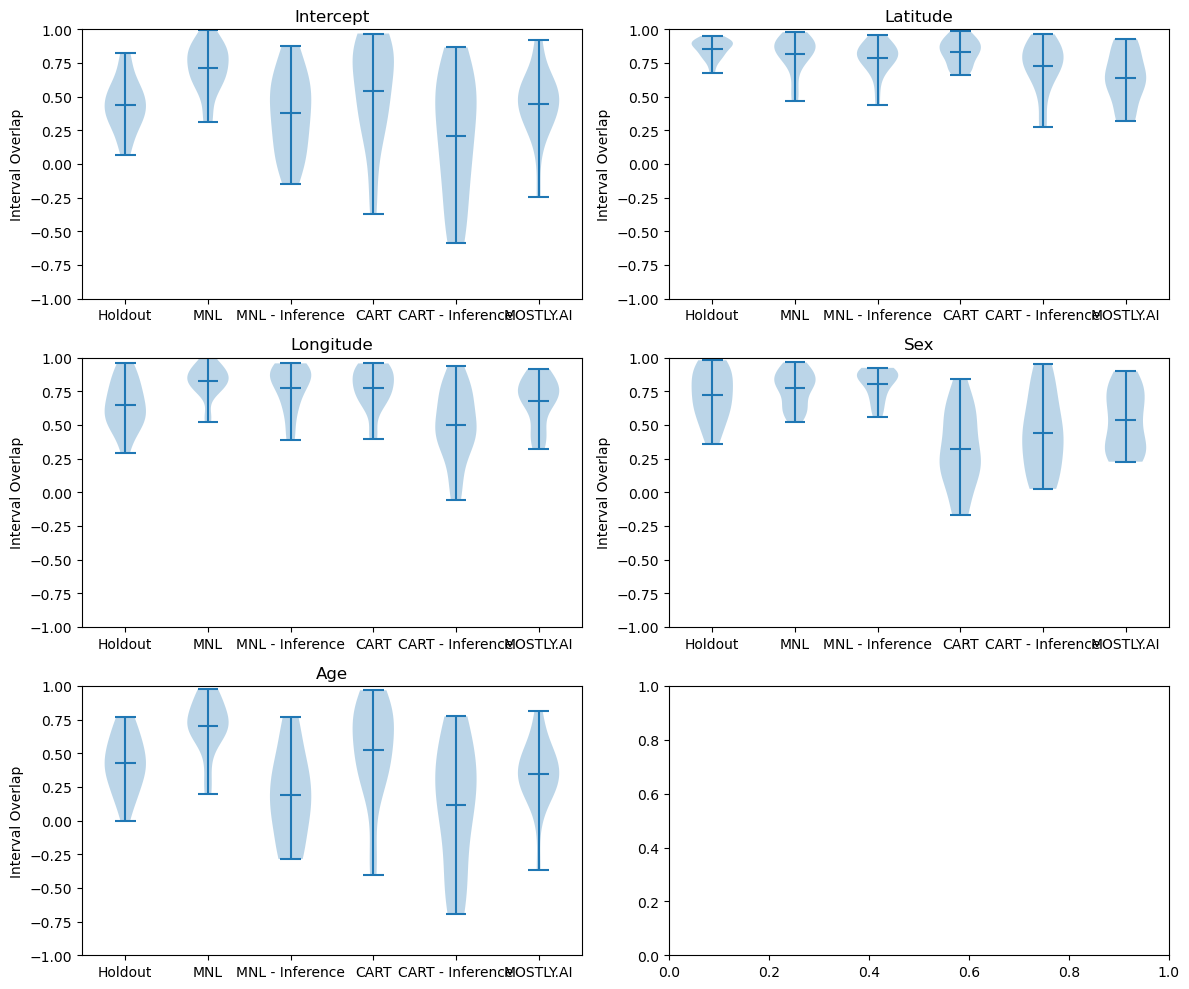

In [182]:
fig, ax = plt.subplots(3, 2, figsize=(12,10))

interval_overlap_plot(ax[0,0], intercept_vals, "Intercept")
interval_overlap_plot(ax[0,1], latitude_vals, "Latitude")
interval_overlap_plot(ax[1,0], longitude_vals, "Longitude")
interval_overlap_plot(ax[1,1], sex_vals, "Sex")
interval_overlap_plot(ax[2,0], age_vals, "Age")

plt.tight_layout()

***

***

Implement a CART model as a user model. Measure the F1-score of a model trained on the holdout or synthetic data set and applied to predicting the confidential data.

In [201]:
cart_state = DecisionTreeClassifier(min_samples_leaf=5)
    
cart_state.fit(X=train_data.loc[:,["latitude", "longitude", "sex", "age"]], y=train_data.loc[:,"state"])

DecisionTreeClassifier(min_samples_leaf=5)

In [217]:
from sklearn.metrics import precision_recall_fscore_support

In [203]:
preds = cart_state.predict(train_data.loc[:,["latitude", "longitude", "sex", "age"]])

In [222]:
precision_recall_fscore_support(train_data.state, preds, average='binary')

(0.8636363636363636, 0.7037037037037037, 0.7755102040816326, None)

In [223]:
f1_score(train_data.state, preds)

0.7755102040816326

In [231]:
def pred_scorer(orig_data, synth_data):
    
    cart_state = DecisionTreeClassifier(min_samples_leaf=5)
    
    cart_state.fit(X=synth_data.loc[:,["latitude", "longitude", "sex", "age"]], y=synth_data.loc[:,"state"])
    
    preds = cart_state.predict(orig_data.loc[:,["latitude", "longitude", "sex", "age"]])
    
    return pd.Series(precision_recall_fscore_support(orig_data.state, preds, average='binary'))

In [234]:
np.median(pd.concat([pred_scorer(train_data, x) for x in holdout_data], axis=1), 1)

array([0.7394958 , 0.44444444, 0.55864703,        nan])

In [235]:
np.median(pd.concat([pred_scorer(train_data, x) for x in sXs_mnl_pmse], axis=1), 1)

array([0.54356061, 0.37037037, 0.4       ,        nan])

In [236]:
np.median(pd.concat([pred_scorer(train_data, x) for x in sXs_mnl_inf_pmse], axis=1), 1)

C:\Users\camer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([ 0.,  0.,  0., nan])

In [237]:
np.median(pd.concat([pred_scorer(train_data, x) for x in sXs_cart_mb_pmse], axis=1), 1)

array([0.44173442, 0.31481481, 0.3712317 ,        nan])

In [238]:
np.median(pd.concat([pred_scorer(train_data, x) for x in sXs_cart_mb_inf_pmse], axis=1), 1)

C:\Users\camer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([ 0.,  0.,  0., nan])

In [239]:
np.median(pd.concat([pred_scorer(train_data, x) for x in sXs_mostly], axis=1), 1)

array([0.5       , 0.5       , 0.49367589,        nan])